In [1]:
import numpy as np
import torch
import pandas as pd

import matplotlib.pyplot as plt

from collections import namedtuple
import seaborn as sns
import os
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import data_processing as dp
import rnn_classifier as ac
import model_utilities_rnn as mu 
import evaluation as ev
import vocab as vo

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = "7"

In [4]:
vocab1, all_labels, sents1, labels1 = dp.load_problem(lang='fr', max_sent_length=100)

In [5]:
vocab1 = vo.Vocab("./embeds_fr.vec", max_sent_length=100)

In [6]:
batch_sampler_1 = mu.BatchSampler(sents=sents1, labels=labels1, vocab=vocab1, all_labels=all_labels, batch_size=128, seed=42)

In [7]:
vocab2, _, sents2, labels2 = dp.load_problem(lang='en', max_sent_length=100)
vocab2 = vo.Vocab("./embeds_en.vec", max_sent_length=100)

In [8]:
batch_sampler_2 = mu.BatchSampler(sents=sents2, labels=labels2, vocab=vocab2, all_labels=all_labels, batch_size=128, seed=42)

In [9]:
batch_sampler_1.test[0][111]

['le',
 'ministère',
 'du',
 'travail',
 'de',
 'l',
 'emploi',
 'et',
 'de',
 'la',
 'sécurité',
 'sociale',
 'a',
 'annoncé',
 'hier',
 'dans',
 'un',
 'communiqué',
 'que',
 'la',
 'journée',
 'de',
 'mardi',
 '1er',
 'novembre',
 '2016',
 'sera',
 '<pad>',
 'et',
 'payée',
 'ce',
 'congé',
 'chômé',
 'et',
 'payé',
 'concerne',
 'l',
 'ensemble',
 'des',
 'personnels',
 'des',
 'institutions',
 'et',
 'administrations',
 'publiques',
 'des',
 'services',
 'spécialisés',
 'des',
 'collectivités',
 'locales',
 'et',
 'les',
 'entreprises',
 'commerciales',
 'industrielles',
 'artisanales',
 'et',
 'agricoles',
 'y',
 'compris',
 'les',
 'personnels',
 'payés',
 'à',
 'l',
 'heure',
 'et',
 'à',
 'la',
 'journée',
 'toutefois',
 'les',
 'personnes',
 'exerçant',
 'en',
 'travail',
 'posté',
 'sont',
 'tenues',
 'd',
 'assurer',
 'la',
 'continuité',
 'du',
 'service',
 'selon',
 'le',
 'règlement',
 'fixé',
 'par',
 'l',
 'employeur']

In [10]:
batch_sampler_2.test[0][111]

['4',
 'colourlovers',
 'viewed',
 'this',
 'page',
 'and',
 'think',
 '<pad>',
 'is',
 'better',
 'than',
 'chocolate',
 'rank',
 'description',
 'bitch',
 'ok',
 'i',
 '<pad>',
 'u',
 'just',
 'called',
 'me',
 'cute',
 'like',
 '20',
 'minutes',
 'ago',
 'but',
 'im',
 '<pad>',
 'u',
 'right',
 'now',
 'boy',
 'u',
 'are',
 'straight',
 'as',
 'fuck',
 'and',
 'u',
 'will',
 'never',
 'have',
 '2',
 'go',
 'through',
 'the',
 'shame',
 'and',
 'terror',
 'and',
 'discomfort',
 'i',
 'have',
 'and',
 'u',
 'will',
 'never',
 'have',
 'to',
 'wonder',
 'if',
 'ur',
 'just',
 'as',
 'real',
 'as',
 'anybody',
 'else',
 'or',
 'why',
 'it',
 'was',
 'u',
 'and',
 'not',
 'the',
 'others',
 'u',
 'wont',
 'so',
 'don',
 't',
 'tell',
 'me',
 'u',
 'think',
 'u',
 'can']

In [28]:
cls = ac.RnnClassifier(100, n_topics=len(all_labels))

In [29]:
cls = cls.cuda()

In [30]:
cls

RnnClassifier(
  (rnn_cell): LSTM(100, 128, batch_first=True)
  (dense): Linear(in_features=128, out_features=256, bias=True)
  (logits_layer): Linear(in_features=256, out_features=26, bias=True)
  (softmax_layer): Softmax()
  (loss_function): CrossEntropyLoss(
  )
  (dropout): Dropout(p=0.5)
)

In [31]:
trainer = mu.Trainer(cls)

In [32]:
# trainer.restore("./rnn_checkpoint.ckpt")

In [33]:
validation_sets = {
    "train_head":batch_sampler_1.get_train_valid(),
    "orig_val":batch_sampler_1.get_valid(),
    "other_val":batch_sampler_2.get_valid(),
}

After epoch  240


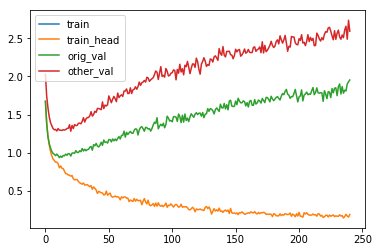

In [53]:
trainer.train(batch_sampler=batch_sampler_1, n_epochs=200, max_iterations=10**5, validation_sets=validation_sets, save_path="./rnn_checkpoint.ckpt", save_every=10)

In [54]:
cls

RnnClassifier(
  (rnn_cell): LSTM(100, 128, batch_first=True)
  (dense): Linear(in_features=128, out_features=256, bias=True)
  (logits_layer): Linear(in_features=256, out_features=26, bias=True)
  (softmax_layer): Softmax()
  (loss_function): CrossEntropyLoss(
  )
  (dropout): Dropout(p=0.5)
)

In [64]:
x_1, mask_1, y_1 = trainer.prepare_data(*batch_sampler_1.get_test())
y_1 = y_1.data.cpu().numpy()

In [65]:
def get_y(y, all_labels):
    res_y = np.zeros(shape=(len(y), len(all_labels)))
    for item_id, cur_label in enumerate(y):
            res_y[item_id, cur_label] = 1
            
    return res_y

In [66]:
y_1 = get_y(y_1, all_labels)

In [67]:
import gc
gc.collect()

29675

In [68]:
trainer.model.eval()

RnnClassifier(
  (rnn_cell): LSTM(100, 128, batch_first=True)
  (dense): Linear(in_features=128, out_features=256, bias=True)
  (logits_layer): Linear(in_features=256, out_features=26, bias=True)
  (softmax_layer): Softmax()
  (loss_function): CrossEntropyLoss(
  )
  (dropout): Dropout(p=0.5)
)

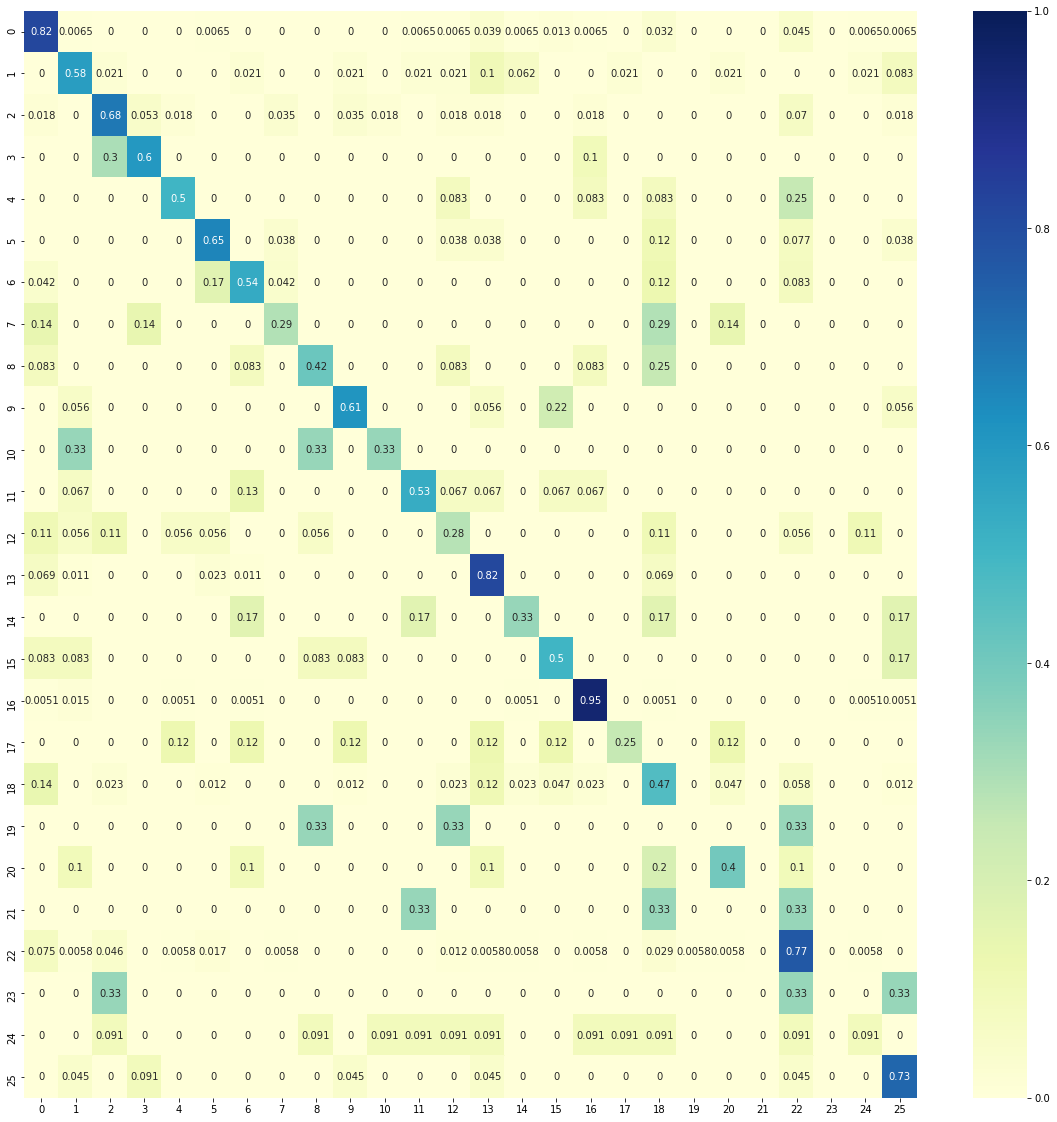

In [69]:
res_1 = ev.describe(trainer, x_1, mask_1, y_1)

In [70]:
res_1

((728, 1024, 0.7109375),
 {0: (126, 165, 0.7636363636363637),
  1: (28, 41, 0.6829268292682927),
  2: (39, 57, 0.6842105263157895),
  3: (6, 12, 0.5),
  4: (6, 11, 0.5454545454545454),
  5: (17, 29, 0.5862068965517241),
  6: (13, 22, 0.5909090909090909),
  7: (2, 7, 0.2857142857142857),
  8: (5, 10, 0.5),
  9: (11, 18, 0.6111111111111112),
  10: (1, 3, 0.3333333333333333),
  11: (8, 13, 0.6153846153846154),
  12: (5, 18, 0.2777777777777778),
  13: (71, 101, 0.7029702970297029),
  14: (2, 10, 0.2),
  15: (6, 18, 0.3333333333333333),
  16: (186, 196, 0.9489795918367347),
  17: (2, 4, 0.5),
  18: (40, 76, 0.5263157894736842),
  19: (0, 1, 0.0),
  20: (4, 12, 0.3333333333333333),
  21: (0, 0, 0.0),
  22: (133, 163, 0.8159509202453987),
  23: (0, 0, 0.0),
  24: (1, 7, 0.14285714285714285),
  25: (16, 30, 0.5333333333333333)},
 {0: (126, 154, 0.8181818181818182),
  1: (28, 48, 0.5833333333333334),
  2: (39, 57, 0.6842105263157895),
  3: (6, 10, 0.6),
  4: (6, 12, 0.5),
  5: (17, 26, 0.653846

In [71]:
# cls.embeddings = vocab2.embeddings
# cls.word_embeddings = torch.nn.Embedding(cls.vocab_size, cls.embedding_dim)
# cls.word_embeddings.weight = torch.nn.Parameter(torch.from_numpy(cls.embeddings).float(), requires_grad=False)


In [72]:
x_2, mask_2, y_2 = trainer.prepare_data(*batch_sampler_2.get_test())
y_2 = get_y(y_2.data.cpu().numpy(), all_labels)

In [73]:
trainer.model.eval()

RnnClassifier(
  (rnn_cell): LSTM(100, 128, batch_first=True)
  (dense): Linear(in_features=128, out_features=256, bias=True)
  (logits_layer): Linear(in_features=256, out_features=26, bias=True)
  (softmax_layer): Softmax()
  (loss_function): CrossEntropyLoss(
  )
  (dropout): Dropout(p=0.5)
)

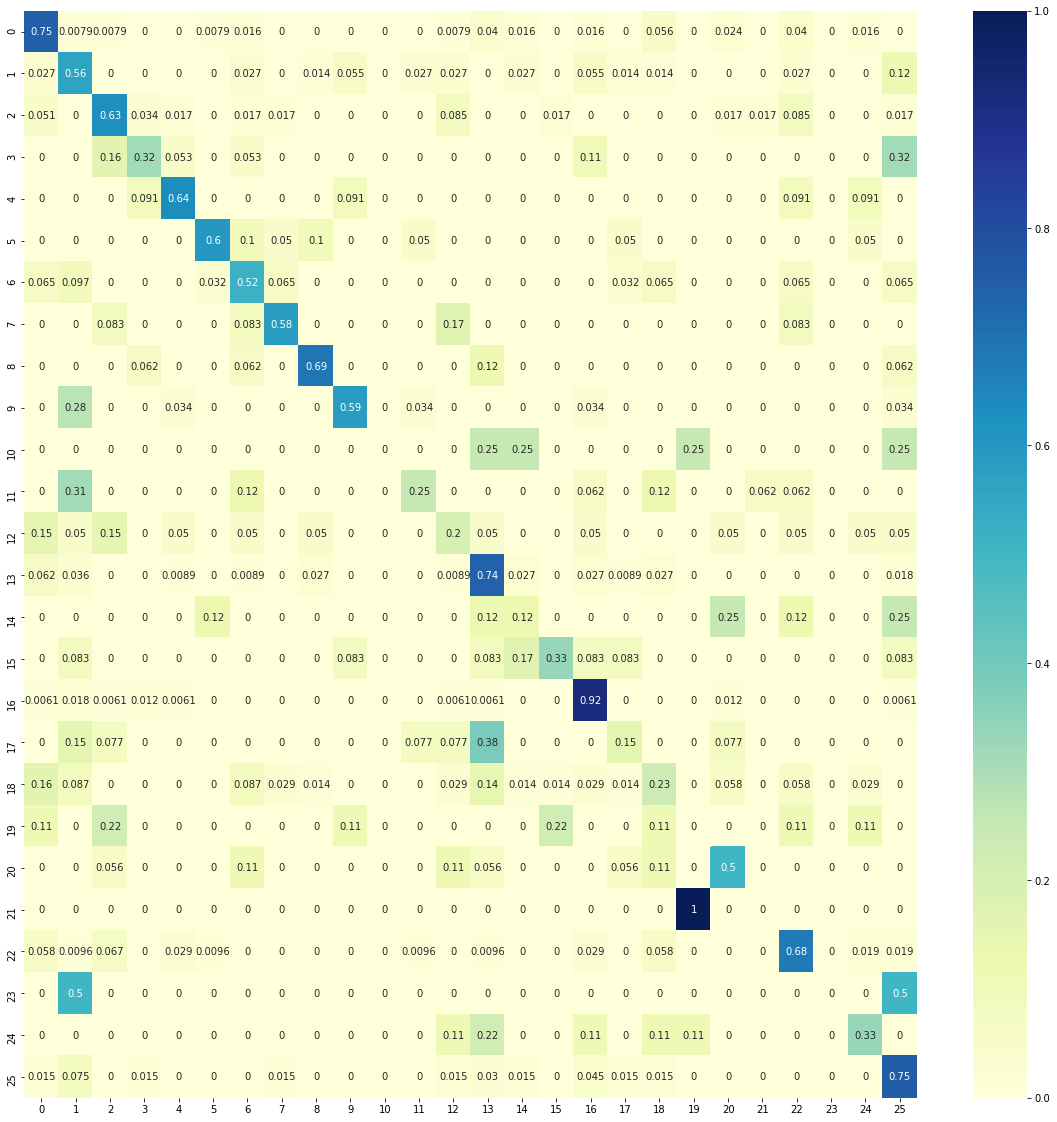

In [74]:
res_2 = ev.describe(trainer, x_2, mask_2, y_2)

In [75]:
res_2

((646, 1024, 0.630859375),
 {0: (94, 131, 0.7175572519083969),
  1: (41, 82, 0.5),
  2: (37, 57, 0.6491228070175439),
  3: (6, 13, 0.46153846153846156),
  4: (7, 16, 0.4375),
  5: (12, 16, 0.75),
  6: (16, 38, 0.42105263157894735),
  7: (7, 14, 0.5),
  8: (11, 19, 0.5789473684210527),
  9: (17, 24, 0.7083333333333334),
  10: (0, 0, 0.0),
  11: (4, 10, 0.4),
  12: (4, 23, 0.17391304347826086),
  13: (83, 116, 0.7155172413793104),
  14: (1, 13, 0.07692307692307693),
  15: (4, 8, 0.5),
  16: (151, 175, 0.8628571428571429),
  17: (2, 10, 0.2),
  18: (16, 42, 0.38095238095238093),
  19: (0, 3, 0.0),
  20: (9, 23, 0.391304347826087),
  21: (0, 2, 0.0),
  22: (71, 95, 0.7473684210526316),
  23: (0, 0, 0.0),
  24: (3, 13, 0.23076923076923078),
  25: (50, 81, 0.6172839506172839)},
 {0: (94, 126, 0.746031746031746),
  1: (41, 73, 0.5616438356164384),
  2: (37, 59, 0.6271186440677966),
  3: (6, 19, 0.3157894736842105),
  4: (7, 11, 0.6363636363636364),
  5: (12, 20, 0.6),
  6: (16, 31, 0.51612903

In [76]:

x = torch.cat((x_1, x_2), 0)
mask = torch.cat((mask_1, mask_2), 0)
y = np.vstack([y_1, y_2])

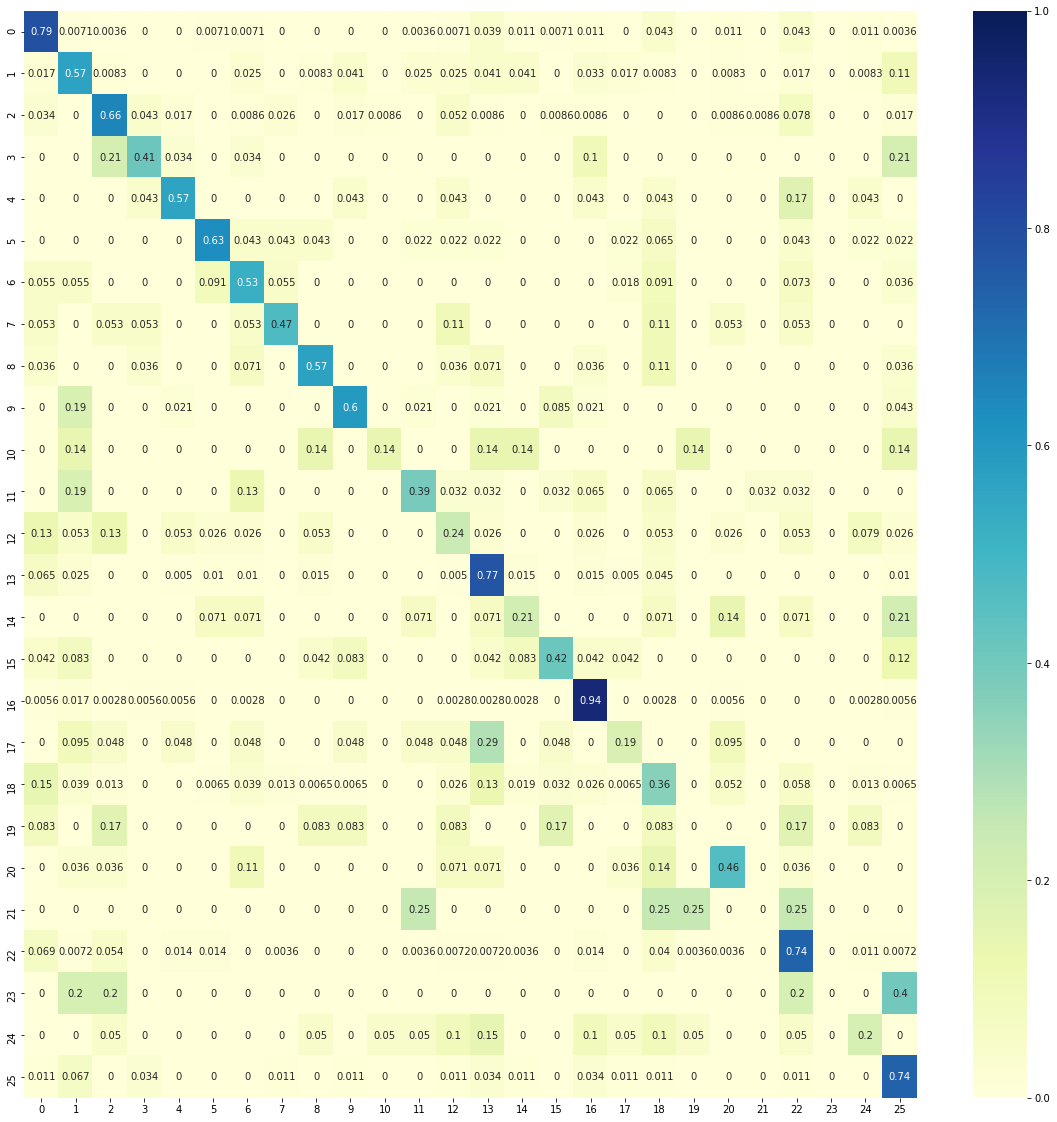

In [77]:
res = ev.describe(trainer, x, mask, y)

In [79]:
res

((1374, 2048, 0.6708984375),
 {0: (220, 296, 0.7432432432432432),
  1: (69, 123, 0.5609756097560976),
  2: (76, 114, 0.6666666666666666),
  3: (12, 25, 0.48),
  4: (13, 27, 0.48148148148148145),
  5: (29, 45, 0.6444444444444445),
  6: (29, 60, 0.48333333333333334),
  7: (9, 21, 0.42857142857142855),
  8: (16, 29, 0.5517241379310345),
  9: (28, 42, 0.6666666666666666),
  10: (1, 3, 0.3333333333333333),
  11: (12, 23, 0.5217391304347826),
  12: (9, 41, 0.21951219512195122),
  13: (154, 217, 0.7096774193548387),
  14: (3, 23, 0.13043478260869565),
  15: (10, 26, 0.38461538461538464),
  16: (337, 371, 0.9083557951482479),
  17: (4, 14, 0.2857142857142857),
  18: (56, 118, 0.4745762711864407),
  19: (0, 4, 0.0),
  20: (13, 35, 0.37142857142857144),
  21: (0, 2, 0.0),
  22: (204, 258, 0.7906976744186046),
  23: (0, 0, 0.0),
  24: (4, 20, 0.2),
  25: (66, 111, 0.5945945945945946)},
 {0: (220, 280, 0.7857142857142857),
  1: (69, 121, 0.5702479338842975),
  2: (76, 116, 0.6551724137931034),
  3